<a href="https://colab.research.google.com/github/rquerino/Reverse-Game-of-Life/blob/master/reverse_game_of_life.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reverse game of life

![cellular automata](https://upload.wikimedia.org/wikipedia/commons/e/e5/Gospers_glider_gun.gif)

Explanation is based on wikipedia             

**Conway's Game of Life**

---
The Game of Life, also known simply as Life, is a cellular automaton devised by the British mathematician John Horton Conway in 1970. The game is a zero-player game, meaning that its evolution is determined by its initial state, requiring no further input. One interacts with the Game of Life by creating an initial configuration and observing how it evolves.

**Rules**

---
1. Any live cell with fewer than two live neighbours dies, as if by underpopulation.
2. Any live cell with two or three live neighbours lives on to the next generation.
3. Any live cell with more than three live neighbours dies, as if by overpopulation.
4. Any dead cell with exactly three live neighbours becomes a live cell, as if by reproduction.



## Game of life simulation
Make your hand dirty to get used to it!

https://bitstorm.org/gameoflife/
<iframe src="https://bitstorm.org/gameoflife/"></iframe>

In [0]:
from IPython.display import IFrame, YouTubeVideo

In [0]:
%%html
<iframe src="https://bitstorm.org/gameoflife/" width="1200" height="1000"></iframe>

## Genetic Algorithm

You don't genetic Algorithm? OMG not awesome! Study this! Be awesome!

### What is Genetic algorithm?

In [0]:
# 9.1 - Genetic Algorithm: Introduction - The Nature of Code
YouTubeVideo('9zfeTw-uFCw', width=1280, height=720)

In [0]:
# 9.2 - Genetic Algorithm: How it works - The Nature of Code
YouTubeVideo('RxTfc4JLYKs', width=1280, height=720)

### Code Practice for Genetic Algorithm

Code is based on the upon youtube

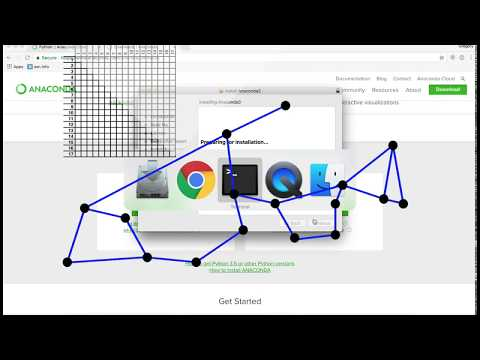

In [0]:
YouTubeVideo('uCXm6avugCo', width=1280, height=720)

In [0]:
import pandas as pd
import numpy as np
import random
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [0]:
def initialize_map(p_zero, N):
    """
    first thing is to create the map that you're trying to navigate.  I will do this randomly.
    This will be of the form of a adjacency matrix...
    In other words, an NxN matrix where each row and column correspond to an intersection on a map
    X_ij, then is equal to the amount of time that it takes to get from position i to position j
    could also be considered a distance measure... but whatever is easier to think about.
    practically, then we need a matrix that has numeric values in it... 
    there should be some paths that don't exist.  I will assign these a 0.  
    For instance, if you can't get directly from i to j, then X_ij = 0
    
    The initialization needs some tuning parameters.  One is the proportion of 0's in the final result
    """
    the_map = np.zeros((N,N))
    for i in range(0, N):
        for j in range(0, i):
            if random.random() > p_zero:
                the_map[i][j] = random.random()
                the_map[j][i] = the_map[i][j]
    return the_map

In [0]:
# Let's make a more complicated map that has at least 10 stops that have to be made and see what happens.
def initialize_complex_map(p_zero, N, groups):
    the_map = np.zeros((N,N))
    for i in range(0, N):
        for j in range(0, i):
            group_i = int(i/(N/groups))
            group_j = int(j/(N/groups))
            if random.random() > p_zero and abs(group_i - group_j) <= 1:
                the_map[i][j] = random.random()
                the_map[j][i] = the_map[i][j]
    ax = sns.heatmap(the_map)
    plt.show()
    return the_map

In [0]:
#this just creates a population of different routes of a fixed size. Pretty straightforward.
def create_starting_population(size, the_map):
    population = []
    for i in range(0,size):
        population.append(create_new_member(the_map))
    return population

In [0]:
def fitness(route, the_map):
    score = 0
    for i in range(1, len(route)):
        if (the_map[route[i-1]][route[i]] == 0) and i != len(the_map)-1:
            print("WARNING: INVALID ROUTE")
            print(route)
            print(the_map)
        score = score + the_map[route[i-1]][route[i]]
    return score

In [0]:
def crossover(a, b):
    """
    I initially made an error here by allowing routes to crossover at any point, which obviously won't work
    you have to insure that when the two routes cross over that the resulting routes produce a valid route
    which means that crossover points have to be at the same position value on the map
    """
    common_elements = set(a) & set(b)
    if len(common_elements) == 2:
        return (a, b)
    else:
        common_elements.remove(0)
        common_elements.remove(max(a)) 
        value = random.sample(common_elements, 1)        

    cut_a = np.random.choice(np.where(np.isin(a, value))[0])
    cut_b = np.random.choice(np.where(np.isin(b, value))[0])
    
    new_a1 = copy.deepcopy(a[0:cut_a])
    new_a2 = copy.deepcopy(b[cut_b:])
    
    new_b1 = copy.deepcopy(b[0:cut_b])
    new_b2 = copy.deepcopy(a[cut_a:])
    
    new_a = np.append(new_a1, new_a2)
    new_b = np.append(new_b1, new_b2)
       
    return (new_a, new_b)

In [0]:
def mutate(route, probability, the_map):
    new_route = copy.deepcopy(route)
    for i in range(1, len(new_route)):
        if random.random() < probability:
            go = True
            while go:
                possible_values = np.nonzero(the_map[new_route[i-1]])
                proposed_value = random.randint(0,len(possible_values[0])-1)
                route = np.append(new_route, possible_values[0][proposed_value])

                if new_route[i] == len(the_map)-1:
                    go = False
                else:
                    i += 1
    return new_route

In [0]:
def create_new_member(the_map):
    """
    here we are going to create a new route
    the new route can have any number of steps, so we'll select that randomly
    the structure of the route will be a vector of integers where each value is the next step in the route
    Everyone starts at 0, so the first value in the vector will indicate where to attempt to go next.
    That is, if v_i = 4, then that would correspond to X_0,4 in the map that was created at initialization
    
    N is the size of the map, so we need to make sure that 
    we don't generate any values that exceed the size of the map
    """
    N = len(the_map)
    route = np.zeros(1, dtype=int)
    go = True
    i = 1
    while go:    
        possible_values = np.nonzero(the_map[route[i-1]])
        proposed_value = random.randint(0,len(possible_values[0])-1)
        route = np.append(route, possible_values[0][proposed_value])
                
        if route[i] == N-1:
            go = False
        else:
            i += 1
    return route

In [0]:
def score_population(population, the_map):
    scores = []
    for i in range(0, len(population)):
        scores += [fitness(population[i], the_map)]    
    return scores

In [0]:
def pick_mate(scores):
    array = np.array(scores)
    temp = array.argsort()
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(len(array))
    fitness = [len(ranks) - x for x in ranks]
    
    cum_scores = copy.deepcopy(fitness)
    for i in range(1,len(cum_scores)):
        cum_scores[i] = fitness[i] + cum_scores[i-1]
        
    probs = [x / cum_scores[-1] for x in cum_scores]
    rand = random.random()
    for i in range(0, len(probs)):
        if rand < probs[i]:
            return i

In [0]:
def plot_best(the_map, route, iteration_number):
    ax = sns.heatmap(the_map)

    x=[0.5] + [x + 0.5 for x in route[0:len(route)-1]] + [len(the_map) - 0.5]
    y=[0.5] + [x + 0.5 for x in route[1:len(route)]] + [len(the_map) - 0.5]
    
    plt.plot(x, y, marker = 'o', linewidth=4, markersize=12, linestyle = "-", color='white')
    # Create a image folder if there nothing
    if (os.path.isdir("/genetic_images") == False):
        os.mkdir("/genetic_images")
    plt.savefig('/genetic_images/new1000plot_%i.png' %(iteration_number), dpi=300)
    plt.show()

In [0]:
def main():
    # parameters
    sparseness_of_map = 0.95
    size_of_map = 100
    population_size = 30
    number_of_iterations = 2000
    number_of_couples = 9
    number_of_winners_to_keep = 2
    mutation_probability = 0.05
    number_of_groups = 1
    
    # initialize the map and save it
    the_map = initialize_complex_map(sparseness_of_map, size_of_map, number_of_groups)

    # create the starting population
    population = create_starting_population(population_size, the_map)

    last_distance = 1000000000
    # for a large number of iterations do:
        
    for i in range(0,number_of_iterations):
        new_population = []
        
        # evaluate the fitness of the current population
        scores = score_population(population, the_map)

        best = population[np.argmin(scores)]
        number_of_moves = len(best)
        distance = fitness(best, the_map)
        
        if distance != last_distance:
            print('Iteration %i: Best so far is %i steps for a distance of %f' % (i, number_of_moves, distance))
            plot_best(the_map, best, i)

        
        # allow members of the population to breed based on their relative score; 
            # i.e., if their score is higher they're more likely to breed
        for j in range(0, number_of_couples):  
            new_1, new_2 = crossover(population[pick_mate(scores)], population[pick_mate(scores)])
            new_population = new_population + [new_1, new_2]
  
        # mutate
        for j in range(0, len(new_population)):
            new_population[j] = np.copy(mutate(new_population[j], 0.05, the_map))
            
        # keep members of previous generation
        new_population += [population[np.argmin(scores)]]
        for j in range(1, number_of_winners_to_keep):
            keeper = pick_mate(scores)            
            new_population += [population[keeper]]
            
        # add new random members
        while len(new_population) < population_size:
            new_population += [create_new_member(the_map)]
            
        #replace the old population with a real copy
        population = copy.deepcopy(new_population)
                
        last_distance = distance
        
    # plot the results

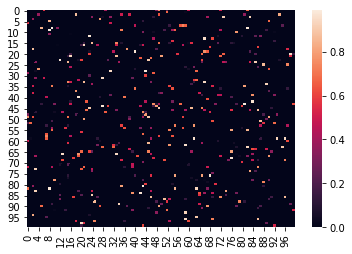

Iteration 0: Best so far is 7 steps for a distance of 3.748715


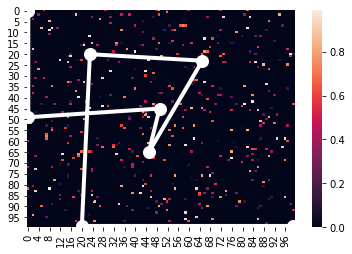

ValueError: ignored

In [0]:
main()

## Dataset

Load the dataset from github and preprocess it to build a dataset to use in machine learning

    - train             [id / step / start board / end board]
    - test              [id / end board]
    - sample submission [id / start board] 

In [0]:
import pandas as pd
import numpy as np

# Import dataset from github
train_pd = pd.read_csv("https://raw.githubusercontent.com/rquerino/Reverse-Game-of-Life/master/resources/train.csv")
test_pd = pd.read_csv("https://raw.githubusercontent.com/rquerino/Reverse-Game-of-Life/master/resources/test.csv")
sample_submission_pd = pd.read_csv("https://raw.githubusercontent.com/rquerino/Reverse-Game-of-Life/master/resources/sampleSubmission.csv")

In [0]:
from tqdm import tqdm_notebook as tqdm
def preprocess_dataset(pandas_dataset, type="train"):
    dataset = {}
    if (type == "train"):
        for data in tqdm(pandas_dataset.values):
            dataset[data[0]] = {"step": data[1],
                                "start": data[2:402].reshape(20, 20),
                                "end": data[402:802].reshape(20, 20)}
    elif (type == "test"):
        for data in tqdm(pandas_dataset.values):
            dataset[data[0]] = {"step": data[1],
                                "end": data[2:402].reshape(20, 20)}
    return dataset

In [0]:
print("Building train set")
train_set = preprocess_dataset(train_pd)
print("Building test set")
test_set = preprocess_dataset(test_pd, type="test")

Building train set



Building test set


## Genetic machine learning



### Utilize tools

- `visualize board` - visualize the conway board using seaborn heatmap
- `check valid game` - Check the conway game model works exactly same as original conway game

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def visualize_board(board):
    plt.figure(figsize=(7, 7))
    sns.heatmap(board,
                square=True,
                linewidths=0.1,
                linecolor='gray',)
                # xticklabels=False,
                # yticklabels=False)

In [0]:
import sys
def check_valid_game(dataset, conway_game):
    total_len = len(dataset)
    correct = 0
    for i in tqdm(range(1, total_len + 1)):
        result = conway_game(dataset[i]["start"], dataset[i]["step"])
        if (result == dataset[i]["end"]).all():
            correct += 1
        sys.stdout.write("\rChecking the game is valid... {} / {}".format(correct, total_len))
        sys.stdout.flush()

### Conway game

Implementing conway game. This wont be used in case of building a neural network model. But will be used when we are directly finding the answer

![cellular automata](https://upload.wikimedia.org/wikipedia/commons/e/e5/Gospers_glider_gun.gif)


In [0]:
from copy import deepcopy

class ConwayGameOfLife(object):
    """Implementation of Conway Game of Life"""
    def __init__(self, board_size):
        """
        Prepare neccesary values

        :param Tuple board_size: (h, w) board height and width
        :param list neighbor_coord: [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]
        :param int width: width
        :param int height: height
        """
        self.neighbor_coord = [(i, j) for i in range(-1, 2) for j in range(-1, 2) if i != 0 or j != 0]
        self.height = board_size[0]
        self.width = board_size[1]

    def __call__(self, board, step):
        return self._process_game(board, step)

    def _neighbor_count(self, board, h, w):
        total = 0
        for n_h, n_w in self.neighbor_coord:
            if (0 <= h + n_h < self.height
                and 0 <= w + n_w < self.width
                and board[h + n_h][w + n_w]):
                    total += 1
        return total
    
    def _evolve(self, board):
        new_board = deepcopy(board)
        for h in range(self.height):
            for w in range(self.width):
                live_num = self._neighbor_count(board, h, w)
                if board[h][w] and not (live_num == 2 or live_num ==3):
                    new_board[h][w] = 0
                elif board[h][w] == 0 and live_num == 3:
                    new_board[h][w] = 1
        return new_board

    def _process_game(self, board, step):
        for _ in range(step):
            board = self._evolve(board)
        return board


In [0]:
# Create the game
game = ConwayGameOfLife((20, 20))

In [0]:
# Check the game is valid compared to the original
check_valid_game(train_set, game)

Checking the game is valid... 50000 / 50000


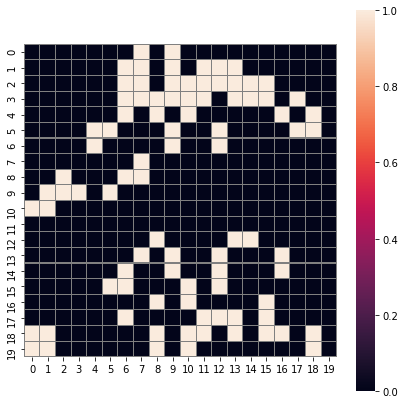

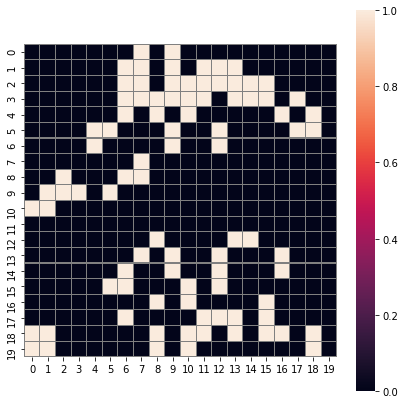

In [0]:
# Check the created game's output and original conway game's output
result = game(train_set[5]["start"], train_set[5]["step"])
visualize_board(result)
visualize_board(train_set[5]["end"])

### Create a model

end board -> model -> start board

    model (hyperparmeter - layer_num, threshold)

**1 step represents one back step**
1. 1 evolve of conway game is 1 step
2. 1 step is has `few number of layers` (20 x 20 matrix)
3. 1 layer is consisted with (20 x 20) matrix and activation layer that will decide to make 0 or 1 depend on the threshold

In [0]:
from copy import deepcopy

class Layer(object):
    """One layer"""
    def __init__(self, layer_size):
        """
        Prepare neccesary values

        :param Tuple layer_size: (h, w) layer height and width 
        """
        self.layer_size = layer_size
        self.weight = None
        self.bias = None

        # create the layer
        self._create_layer()
    
    def __call__(self, x, activation=True):
        return self._forward(x, activation)

    def __str__(self):
        return "weight\nshape : {}\n{}\n\nbias\nshape : {}\n{}\n".format(self.weight.shape,
                                                                         self.weight,
                                                                         self.bias.shape,
                                                                         self.bias)

    def __repr__(self):
        return "Layer({})".format(self.layer_size)
    
    def _create_layer(self):
        self._weight_initialize()
        self._bias_initialize()

    def _weight_initialize(self):
        self.weight = np.random.randn(self.layer_size[0],
                                      self.layer_size[1])
        mean = self.weight.mean()
        var = 2 / (self.layer_size[0] + self.layer_size[1]) # Var(W_i) = 2 / (n_in + n_out)

        # Z score
        self.weight = ((self.weight - mean) / var)

    def _bias_initialize(self):
        self.bias = np.random.randn(self.layer_size[1])

    def _activation(self, x):
        # This is ReLU activation
        x_shape = x.shape
        x = x.reshape(-1)
        x[np.where((x < 0).reshape(-1))] = 0
        return x.reshape(x_shape)

    def _forward(self, x, activation):
        if activation:
            return self._activation((x @ self.weight) + self.bias)
        else:
            return (x @ self.weight + self.bias)

In [0]:
class MultiLayers(object):
    """Multi layers"""
    def __init__(self, layer_num, threshold, layer_size_list=None):
        """
        Prepare neccesary values

        :param Tuple layer_size_list: [(h, w), ... , (h, w)]
            -> list of layer size tuples height and width
            -> if None fill the list to default value (20, 20)
        """
        self.layer_num = layer_num
        self._threshold = threshold
        self.layer_size_list = None
        self.layer_list = []

        # Initialize layers size
        if (layer_size_list):
            self.layer_size_list = layer_size_list
        else:
            self.layer_size_list = [(20, 20) for _ in range(self.layer_num)]

        # Initialize layers
        self._create_layers()

    def __call__(self, x):
        return self._forward(x)

    def __str__(self):
        status = ""
        for i in range(1, self.layer_num + 1):
            status += "layer {}\n".format(i)
            status += str(self.layer_list[i - 1])
            status += "\n"
        return status
    
    def __repr__(self):
        return "MultiLayers({}, {}, {})".format(self.layer_num,
                                                self._threshold,
                                                self.layer_size_list)
        
    def change_threshold(self, threshold):
        print("Threshold changed from {} ".format(self._threshold), end="")
        self._threshold = threshold
        print("to {}".format(self._threshold))
        

    def _create_layers(self):
        for layer_size in self.layer_size_list:
            self.layer_list.append(Layer(layer_size))
    
    def _create_board(self, x):
        x_shape = x.shape
        x = x.reshape(-1)
        x[np.where((x >= self._threshold).reshape(-1))] = 1
        x[np.where((x < self._threshold).reshape(-1))] = 0
        return x.reshape(x_shape)
    
    def _forward(self, x):
        for i, layer in enumerate(self.layer_list):
            if (i == (self.layer_num - 1)):
                # Don't apply ReLU activation at the last layer
                x = layer(x, activation=False)
            else:
                x = layer(x)
        
        # Apply threshold
        return self._create_board(x)


In [0]:
l = MultiLayers(2, 0.5)

In [243]:
l

MultiLayers(2, 0.5, [(20, 20), (20, 20)])

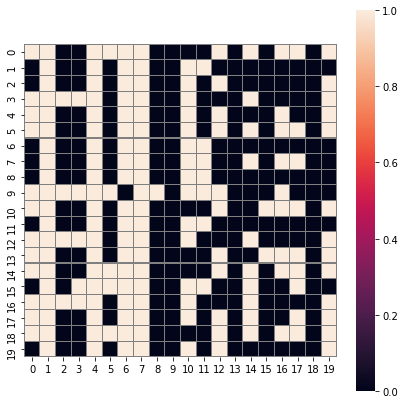

In [270]:
result = l(result)
visualize_board(result)

In [245]:
l.change_threshold(0.5)

Threshold changed from 0 to 0.5


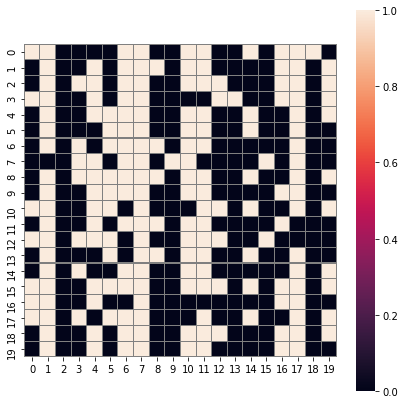

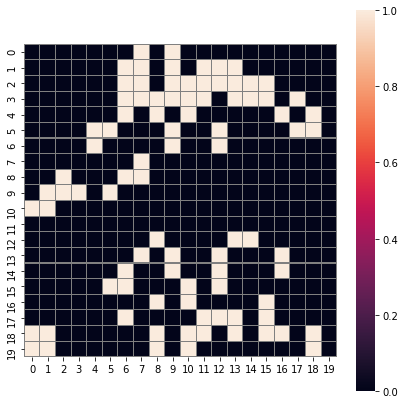

In [246]:
# Test is the multi layer is working
result = l(train_set[5]["start"])
visualize_board(result)
visualize_board(train_set[5]["end"])

In [0]:
w = np.random.rand(3, 2)

In [144]:
w = l(w)
print(w)

[[2.34207218 0.         0.1992841 ]
 [5.03511597 0.         0.23610978]
 [3.22490787 0.         0.6253408 ]]


In [188]:
b = np.array([1, 2, 3])
print (w + b)

[[3.34207218 2.         3.1992841 ]
 [6.03511597 2.         3.23610978]
 [4.22490787 2.         3.6253408 ]]


In [0]:
import numpy as np
tests = np.random.binomial(5, 0.5, size=2)
print(tests)

[3 2]
